# Daily Deliveries
## Capacitated Vehicle Routing Problem (CVRP)

Micro fulfillment centers allow retailers to move predictable, high volume products closer to the end consumer allowing for lower costs and shorter overall delivery times.

In this scenario we have a number of same-day delivery orders that we would like to process for a given area from a given micro fulfillment center. We have the requisite number of delivery vehicles and enough time to deliver all packages over the course of a single day. Each delivery vehicle has a maximum capacity of orders it can carry and we are looking for the route assignment that minimizes the total distance driven by all vehicles.

### Problem Details:
- 8 Locations each with an associated demand
    - 1 MFC 
        - demand: [0]
    - 7 Delivery Locations
        - demand: [4, 4, 2, 2, 1, 2, 1]
    

- 3 Delivery vehicles each with an associated capacity
    - 2 trucks
        - capacity: [8, 8]
    - 1 van
        - capacity: [4]
        

Below we visualize the delivery locations with respect to the MFC. The cost from all locations to all other locations (a cost matrix) will be required for optimization. To see an example of cost matrix generation from map data or a waypoint graph, refer to the [cost_matrix_and_waypoint_graph_creation.ipynb](../intra-factory_transport/cost_matrix_and_waypoint_graph_creation.ipynb) notebook. For the purpose of this simple example we will omit the cost matrix calculation.

### Environment Setup
First, let's check if we have a GPU available in this Colab environment.

In [2]:
# Check for GPUs
!nvidia-smi

Tue May 20 11:09:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 8000                Off |   00000000:61:00.0  On |                  Off |
| 33%   44C    P8             37W /  260W |    2279MiB /  49152MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Install dependencies

In [3]:
# Install cuOpt

# Enable this in case you are running this in google colab or such places where cuOpt is not yet installed

# This would be incase underlying system is cuda-11.X 
# !pip install --user cuopt-cu11==25.5.* 

# This would be incase underlying system is cuda-12.x
# !pip install --user cuopt-cu12==25.5.*

In [ ]:
# Install notebook dependencies
!pip install --user -q matplotlib

In [4]:
import os
import pandas as pd
import numpy as np
import cudf
from cuopt import routing
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

/home/luffy/.local/lib/python3.12/site-packages/cupy/_environment.py:541: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


#### Utility functions

These function are used to generate the plot of the locations and the routes.

In [7]:
# Used to plot the Co-ordinates
def gen_plot(df):
    """
    Generate a plot with the locations.
    
    Args:
        df: DataFrame with location coordinates (xcord, ycord)
        
    Returns:
        matplotlib plot object
    """
    plt.figure(figsize=(11, 11))
    
    # Plot depot (first location)
    plt.scatter(
        df["xcord"][:1],
        df["ycord"][:1],
        label="Depot",
        color="Green",
        marker="o",
        s=100,
    )
    
    # Plot other locations
    plt.scatter(
        df["xcord"][1:],
        df["ycord"][1:],
        label="Locations",
        color="Red",
        marker="o",
        s=100,
    )
    
    plt.xlabel("x - axis")
    plt.ylabel("y - axis")
    plt.title("Simplified Map")
    plt.legend()

    # Add location labels
    for i, label in enumerate(df.index.values):
        plt.annotate(
            label,
            (df["xcord"][i], df["ycord"][i]),
            fontproperties=fm.FontProperties(size=16),
        )
    
    return plt


# Used to plot arrows
def add_arrows(df, route, plt, color="green"):
    """
    Add directional arrows to the plot to represent a route.
    
    Args:
        df: DataFrame with location coordinates
        route: List of location indices representing the route
        plt: matplotlib plot object
        color: Color for the arrows
        
    Returns:
        matplotlib plot object with arrows added
    """
    prev_cord = ()
    for i, label in enumerate(route):
        if i > 0:
            arrow_props = dict(
                arrowstyle="simple, head_length=0.5, head_width=0.5, tail_width=0.15",
                connectionstyle="arc3",
                color=color,
                mutation_scale=20,
                ec="black",
            )
            plt.annotate(
                "",
                xy=(df["xcord"][label], df["ycord"][label]),
                xytext=prev_cord,
                arrowprops=arrow_props,
                label=f"vehicle-{i}",
            )
        prev_cord = df["xcord"][label], df["ycord"][label]

    return plt


# Convert the solver response to a pandas dataframe for mapping
def get_solution_df(solution):
    """
    Converts a solution object to a pandas DataFrame
    
    Args:
        solution: A cuOpt routing.Solution object
    
    Returns:
        pandas.DataFrame: Contains the route information
    """
    # Check if it's a new API solution object
    if hasattr(solution, 'get_route'):
        # New API solution object
        routes_df = solution.get_route()
        return routes_df.to_pandas() if hasattr(routes_df, 'to_pandas') else routes_df
    
    # Check if it's a dictionary with vehicle_data key (legacy API)
    if isinstance(solution, dict) and "vehicle_data" in solution:
        solution_dict = solution["vehicle_data"]
        df = {}
        df["route"] = []
        df["truck_id"] = []
        df["location"] = []
        types = []

        for vid, route in solution_dict.items():
            df["location"] = df["location"] + route["route"]
            df["truck_id"] = df["truck_id"] + [vid] * len(route["route"])
            if "type" in list(route.keys()):
                types = types + route["type"]
        if len(types) != 0:
            df["types"] = types
        df["route"] = df["location"]

        return pd.DataFrame(df)
    
    # If solution is already a DataFrame, return it directly
    if isinstance(solution, pd.DataFrame):
        return solution
        
    # If we reach here, we don't recognize the format
    raise TypeError("Unrecognized solution format. Must be a Solution object, a response dictionary, or a DataFrame.")


# Prints vehicle routes
def show_vehicle_routes(solution, locations):
    """
    Print the vehicle routes in a readable format.
    
    Args:
        solution: cuOpt routing.Solution object
        locations: List of location names corresponding to indices
    """
    # Get route DataFrame from solution
    routes_df = solution.get_route()
    
    # Convert to pandas if it's a cudf DataFrame
    if hasattr(routes_df, 'to_pandas'):
        routes_df = routes_df.to_pandas()
        
    # Display routes for each vehicle
    for v_id in routes_df['truck_id'].unique():
        vehicle_route = routes_df[routes_df['truck_id'] == v_id]
        route_locations = vehicle_route['route'].tolist()
        
        print(f"For vehicle {v_id} route is:")
        path_parts = [locations[loc] for loc in route_locations]
        route_str = " → ".join(path_parts)
        print(route_str)
        print()


# Map vehicle routes
def map_vehicle_routes(df, solution, colors):
    """
    Creates a plot visualizing vehicle routes.
    
    Args:
        df: DataFrame with location coordinates
        solution: cuOpt routing.Solution object
        colors: List of colors to use for different vehicles
    
    Returns:
        matplotlib plot object with routes visualized
    """
    # Initialize plot with locations
    plt = gen_plot(df)
    
    # Get routes from solution
    routes_df = solution.get_route()
    
    # Convert to pandas if it's a cudf DataFrame
    if hasattr(routes_df, 'to_pandas'):
        routes_df = routes_df.to_pandas()
        
    # Get unique vehicle IDs
    vehicle_ids = routes_df['truck_id'].unique()
    
    # Create a mapping from vehicle ID to color index
    vid_map = {vid: i % len(colors) for i, vid in enumerate(vehicle_ids)}
    
    # Draw routes for each vehicle
    for v_id in vehicle_ids:
        v_route = routes_df[routes_df['truck_id'] == v_id]
        route_locs = v_route['route'].tolist()
        plt = add_arrows(
            df, 
            route_locs,
            plt, 
            color=colors[vid_map[v_id]]
        )
    
    return plt

/tmp/ipykernel_3591836/857199254.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df["xcord"][i], df["ycord"][i]),


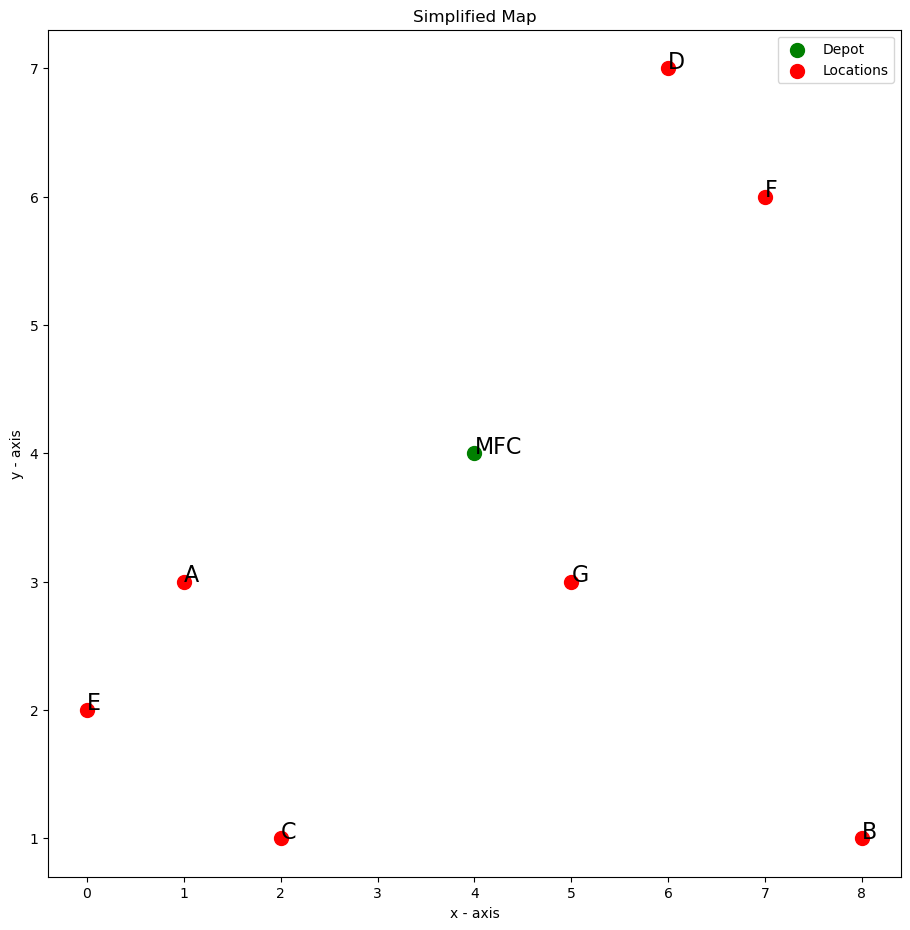

In [8]:
location_names       = [ "MFC",     "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [ [4, 4],    [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3] ]
location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)
gen_plot(location_coordinates_df).show()

### Cost Matrix

The cost matrix dictates the cost of travel between locations of interest. The cost itself can be anything relevant to the user. In this case we simply use distance as our cost.

Here is the cost(distance) matrix corresponding to the above locations:

In [9]:
distance_matrix = [
    [0.0, 3.1, 5.0, 3.6, 3.6, 4.5, 3.6, 1.4],
    [3.1, 0.0, 7.3, 2.2, 6.4, 1.4, 6.7, 4.0],
    [5.0, 7.3, 0.0, 6.0, 6.3, 8.1, 5.1, 3.6],
    [3.6, 2.2, 6.0, 0.0, 7.2, 2.2, 7.1, 3.6],
    [3.6, 6.4, 6.3, 7.2, 0.0, 7.8, 1.4, 4.1],
    [4.5, 1.4, 8.1, 2.2, 7.8, 0.0, 8.1, 5.1],
    [3.6, 6.7, 5.1, 7.1, 1.4, 8.1, 0.0, 3.6],
    [1.4, 4.0, 3.6, 3.6, 4.1, 5.1, 3.6, 0.0]
]

# Convert to cudf DataFrame for cuOpt
distance_matrix_df = cudf.DataFrame(np.array(distance_matrix).astype(np.float32))
distance_matrix_df

,0,1,2,3,4,5,6,7
0,0.0,3.1,5.0,3.6,3.6,4.5,3.6,1.4
1,3.1,0.0,7.3,2.2,6.4,1.4,6.7,4.0
2,5.0,7.3,0.0,6.0,6.3,8.1,5.1,3.6
3,3.6,2.2,6.0,0.0,7.2,2.2,7.1,3.6
4,3.6,6.4,6.3,7.2,0.0,7.8,1.4,4.1
5,4.5,1.4,8.1,2.2,7.8,0.0,8.1,5.1
6,3.6,6.7,5.1,7.1,1.4,8.1,0.0,3.6
7,1.4,4.0,3.6,3.6,4.1,5.1,3.6,0.0


 ### Demand and Capacity

Set up the demand for each location and the capacity for each vehicle

In [10]:
# All locations including the MFC
location_demand = cudf.Series([0, 4, 4, 2, 2, 1, 2, 1], dtype=np.int32)

# Vehicle capacities
vehicle_capacity = cudf.Series([8, 8, 4], dtype=np.int32)
n_vehicles = len(vehicle_capacity)

# Initialize cuOpt Problem Model

In [11]:
# Create a routing model with 8 locations (including depot) and 3 vehicles
n_locations = len(location_demand)
data_model = routing.DataModel(n_locations, n_vehicles)

### Set Cost Matrix

Add the cost matrix to the model

In [12]:
# Add the distance matrix as our cost matrix
data_model.add_cost_matrix(distance_matrix_df)

### Set Demand and Capacity

Add demand and capacity data to the model

In [13]:
# Add demand and capacity dimension
data_model.add_capacity_dimension("demand", location_demand, vehicle_capacity)

### Set Vehicle Data

Set vehicle start locations (all at depot 0)

In [14]:
# All vehicles start and end at the depot (location 0)
veh_start_locations = cudf.Series([0, 0, 0])
veh_end_locations = cudf.Series([0, 0, 0])
data_model.set_vehicle_locations(veh_start_locations, veh_end_locations)

### Set Solver Settings

Configure the solver

In [15]:
# Create solver settings
solver_settings = routing.SolverSettings()
solver_settings.set_time_limit(5)

### Get Optimized Routes

In [16]:
# Solve the problem
solution = routing.Solve(data_model, solver_settings)

# Process returned data
if solution.get_status() == 0:  # Success
    print("Cost for the routing in distance: ", solution.get_total_objective())
    print("Vehicle count to complete routing: ", solution.get_vehicle_count())
    
    # Get the routes
    routes_df = solution.get_route()
    
    # Display the routes by vehicle
    for vehicle_id in routes_df['truck_id'].unique().to_pandas():
        vehicle_route = routes_df[routes_df['truck_id'] == vehicle_id]
        route_locations = vehicle_route['route'].to_arrow().to_pylist()
        route_names = [location_names[loc] for loc in route_locations]
        print(f"Vehicle {vehicle_id} route: {' → '.join(route_names)}")
else:
    print("NVIDIA cuOpt Failed to find a feasible solution. Status:", solution.get_status())

Cost for the routing in distance:  26.799999594688416
Vehicle count to complete routing:  2
Vehicle 0 route: MFC → A → E → C → G → MFC
Vehicle 1 route: MFC → D → F → B → MFC


/tmp/ipykernel_3591836/857199254.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df["xcord"][i], df["ycord"][i]),
/tmp/ipykernel_3591836/857199254.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_cord = df["xcord"][label], df["ycord"][label]
/tmp/ipykernel_3591836/857199254.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(df["xcord"][label], df["ycord"][label]),


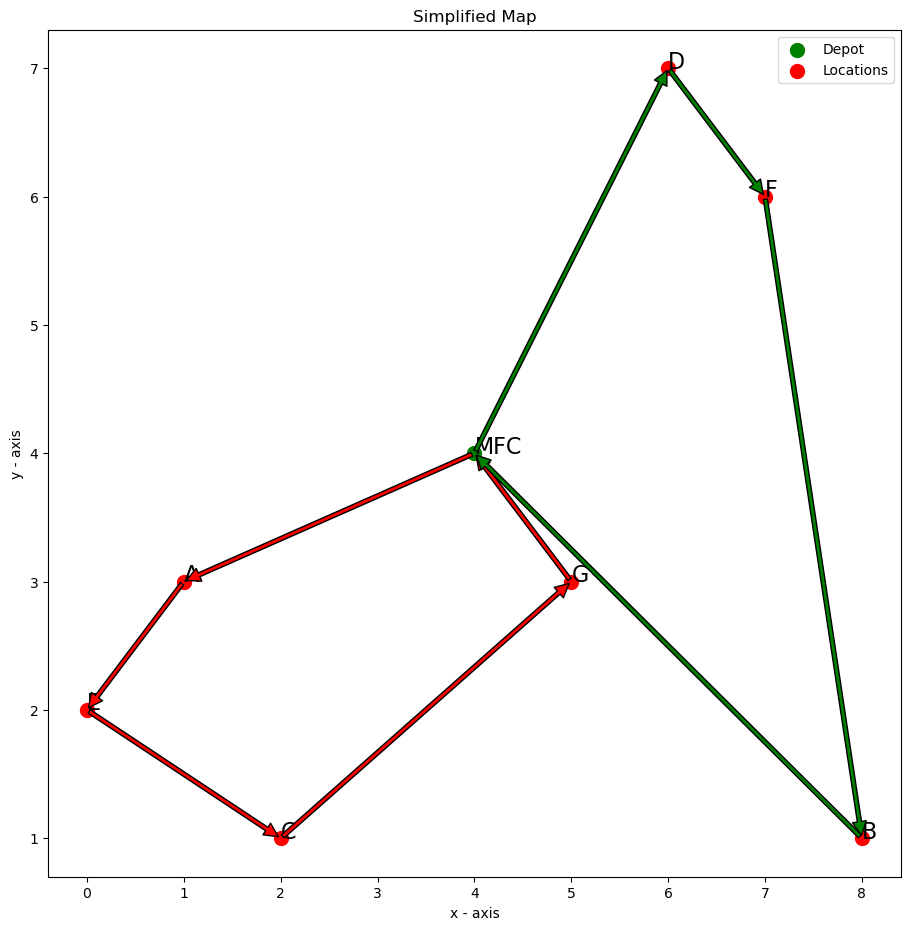

In [17]:
# Display the routes visually
vehicle_colors = ["red", "green", "blue"]
map_vehicle_routes(location_coordinates_df, solution, vehicle_colors).show()

### Additional Constraints 
##### Minimum Vehicles

cuOpt has found a solution that does not require all available vehicles because the combined capacity of the two larger vehicles (16) is equal to total location demand (16).  In some cases, this is a great solution as it gives the option to save on the costs associated with additional vehicles.  In other cases there is value to assigning all available resources.  In the latter case we can require that cuOpt use all 3 available vehicles and re-solve the problem with this constraint.

**Update the model with minimum vehicles constraint and re-optimize**

In [18]:
# Set minimum vehicles constraint
data_model.set_min_vehicles(n_vehicles)

In [19]:
# Re-solve the problem
solution = routing.Solve(data_model, solver_settings)

# Process returned data
if solution.get_status() == 0:  # Success
    print("Cost for the routing in distance: ", solution.get_total_objective())
    print("Vehicle count to complete routing: ", solution.get_vehicle_count())
    
    # Get the routes
    routes_df = solution.get_route()
    
    # Display the routes by vehicle
    for vehicle_id in routes_df['truck_id'].unique().to_pandas():
        vehicle_route = routes_df[routes_df['truck_id'] == vehicle_id]
        route_locations = vehicle_route['route'].to_arrow().to_pylist()
        route_names = [location_names[loc] for loc in route_locations]
        print(f"Vehicle {vehicle_id} route: {' → '.join(route_names)}")
else:
    print("NVIDIA cuOpt Failed to find a feasible solution. Status:", solution.get_status())

Cost for the routing in distance:  28.199999570846558
Vehicle count to complete routing:  3
Vehicle 2 route: MFC → G → MFC
Vehicle 0 route: MFC → A → E → C → MFC
Vehicle 1 route: MFC → B → F → D → MFC


/tmp/ipykernel_3591836/857199254.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df["xcord"][i], df["ycord"][i]),
/tmp/ipykernel_3591836/857199254.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_cord = df["xcord"][label], df["ycord"][label]
/tmp/ipykernel_3591836/857199254.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(df["xcord"][label], df["ycord"][label]),


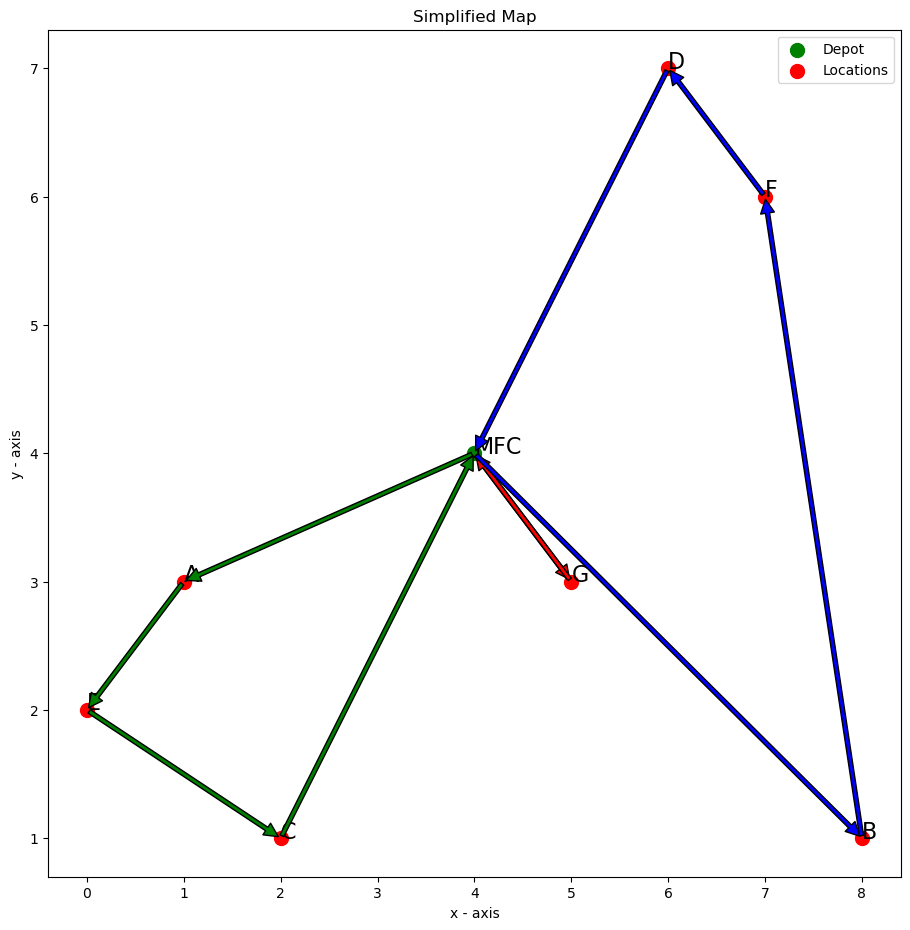

In [21]:
# Display the updated routes visually
map_vehicle_routes(location_coordinates_df, solution, vehicle_colors).show()


SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.